# Qualitative results

### Imports

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from IPython.display import HTML, display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
# from data_mani.visu import *
from prediction.functions import aggregate_prediction_results, gen_strat_positions_and_ret_from_pred, ann_avg_returns_tb, ann_vol_tb, max_drawdown_tb, sharpe_ratio_tb, plot_cum_ret
from time import time
init = time()

plt.style.use('bmh')

### Variables

In [11]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3'] + ['average', 'median', 'bg', 'nncomb']
models2 = ['LOGIT', 'RIDGE', 'LASSO', 'ENET', 'RF', 'GB', 'NN3'] + ['AVERAGE', 'MEDIAN', 'BG', 'NNCOMB']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
fs_methods2 = ['ALL', 'SFI', 'MDI', 'MDA', 'GRANGER', 'HUANG', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"
oos_start_date = '2012-07-03'
oos_end_date = '2020-12-31'

# Main reference

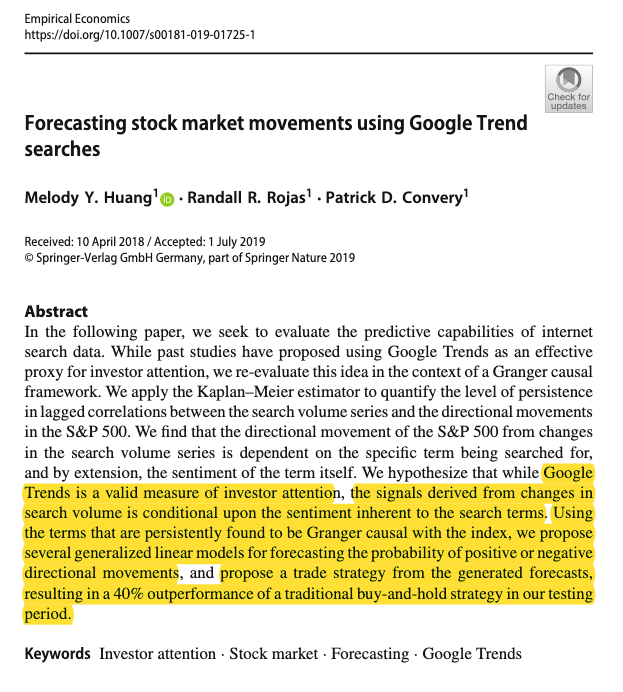

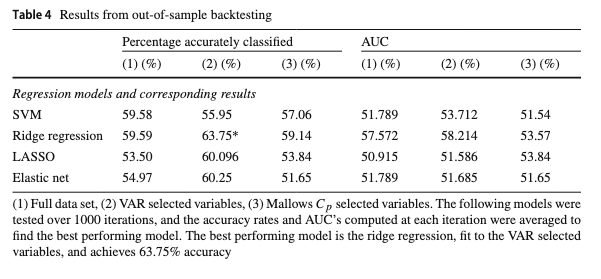

# Our models


## Feature Selection

> 1. All

> 2. Mean decrease impurity (random forest based) - MDI

> 3. Mean decrease accuracy (oos loss of performance; class based) - MDA

> 4. Single feature importance (oos individual feature; reg based) - SFI

> 5. Grenger causality - GRANGER

> 6. Granger causality + Logit - HUANG

> 7. Incremental association Markov boundary - IAMB

> 8. Max-Min Markov boundary - MMMB


## Prediction Models

> 1. Logit

> 2. Ridge regression

> 3. Lasso regression

> 4. Elastic net regression

> 5. Random Forest

> 6. Gradient Boosting

> 7. LSTM neural network (three layer)

## Prediction Setup

> 0. Sample from '2004-01-01' to '2020-12-31'

> 1. Feature selection: '2004-01-01' to '2012-07-03'

> 2. Forecasting: '2012-07-04' to '2020-12-31'

>> a. Random Search

>> b. Predict next year

>> c. Increase sample

# Aggregate prediction results

In [12]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)

In [43]:
fs_methods

['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']

In [13]:
oos_melt_predictions_df, oos_melt_benchmark_df, oos_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                               fs_models=fs_methods,
                                                                                               evaluation_start_date=oos_start_date,
                                                                                               evaluation_end_date=oos_end_date,
                                                                                               ticker_names=tickers,
                                                                                               metric_name=metric,
                                                                                               tag='oos',
                                                                                               benchmark_name=benchmark_name)

/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


In [14]:
is_melt_predictions_df, is_melt_benchmark_df, is_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                            fs_models=fs_methods,
                                                                                            evaluation_start_date='2005-01-03',
                                                                                            evaluation_end_date='2012-07-03',
                                                                                            ticker_names=tickers,
                                                                                            metric_name=metric,
                                                                                            tag='is',
                                                                                            benchmark_name=benchmark_name)

/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


## 1) AUC Analysis

### 1.1) In sample AUC median values

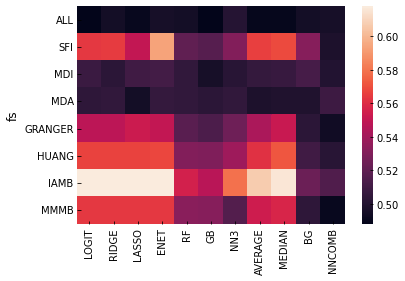

In [15]:
is_auc_df = is_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['isauc'], aggfunc='median')
simple_cols = [c[1] for c in is_auc_df.columns]
is_auc_df.columns = simple_cols
is_auc_df = is_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) In sample AUC median values"))
display(HTML(is_auc_df.to_html()))
sns.heatmap(is_auc_df);

In [16]:
# print((is_auc_df * 100).reset_index().to_latex(index=False))

### 1.2) Out of sample AUC median values

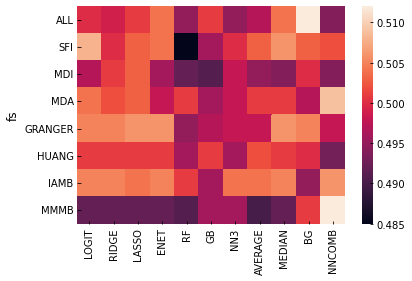

In [17]:
oos_auc_df = oos_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_auc_df.columns]
oos_auc_df.columns = simple_cols
oos_auc_df = oos_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values"))
display(HTML(oos_auc_df.to_html()))
sns.heatmap(oos_auc_df);

In [18]:
# print((oos_auc_df * 100).reset_index().to_latex(index=False))

### 1.3) Out of sample AUC distribution across forecasting models

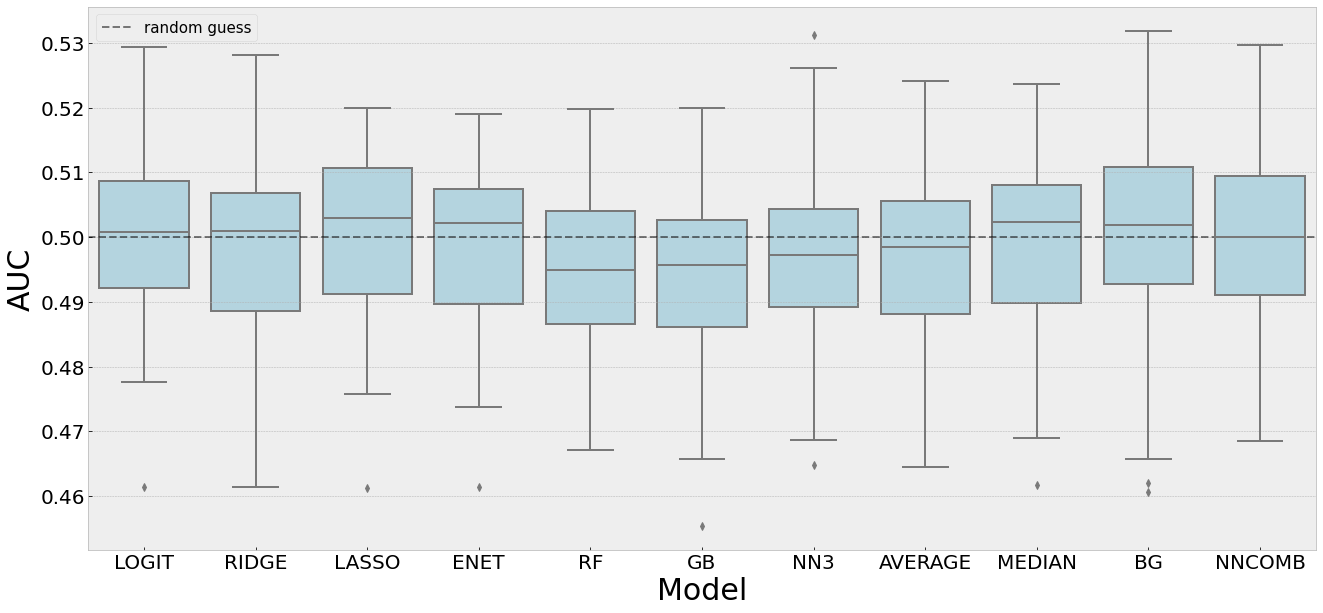

In [19]:
display(Markdown("### 1.3) Out of sample AUC distribution across forecasting models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',data=oos_melt_auc_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr.png')

### 1.4) Out of sample AUC distribution across feature selection methods

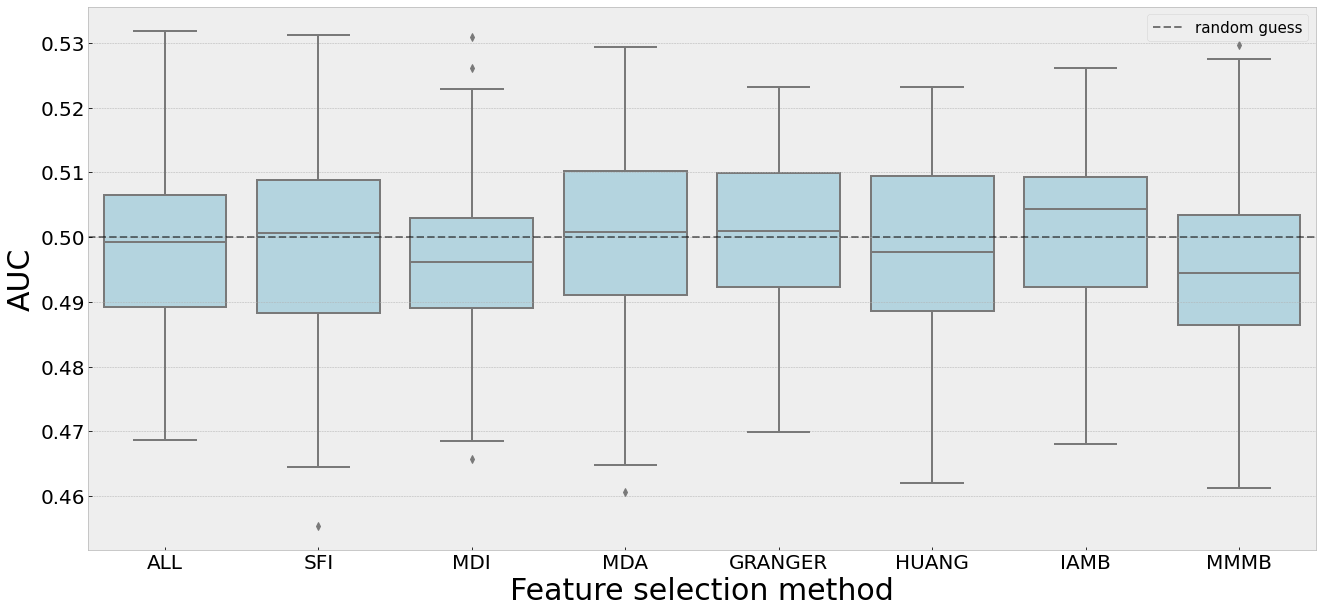

In [20]:
display(Markdown("### 1.4) Out of sample AUC distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_melt_auc_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr.png')

### 1.2) Out of sample AUC median values (SPX index only)

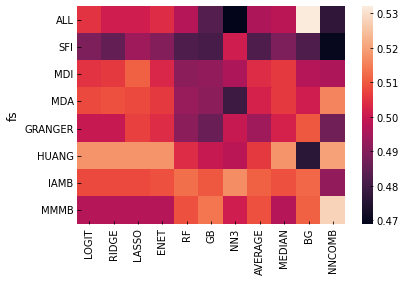

In [21]:
oos_spx_auc_df = oos_melt_auc_df[oos_melt_auc_df["ticker"] == "SPX Index"].reset_index(drop=True)

oos_spx_auc_df1 = oos_spx_auc_df.copy()
oos_spx_auc_df1 = oos_spx_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_spx_auc_df1.columns]
oos_spx_auc_df1.columns = simple_cols
oos_spx_auc_df1 = oos_spx_auc_df1.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values (SPX index only)"))
display(HTML(oos_spx_auc_df1.to_html()))
sns.heatmap(oos_spx_auc_df1);

### 1.5) Out of sample AUC distribution across forecasting models (SPX index only)

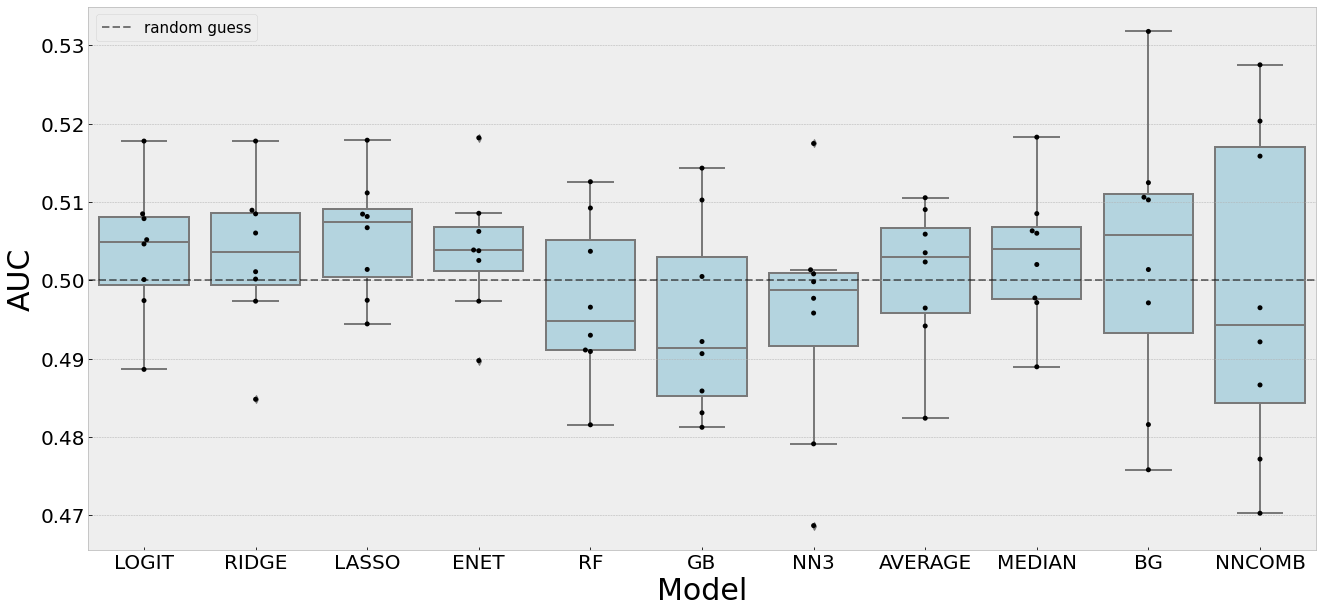

In [22]:
display(Markdown("### 1.5) Out of sample AUC distribution across forecasting models (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',
            data=oos_spx_auc_df, ax=ax, order=models2, color='lightblue');
sns.swarmplot(x="model", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=models2)

ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr_spx.png')


### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)

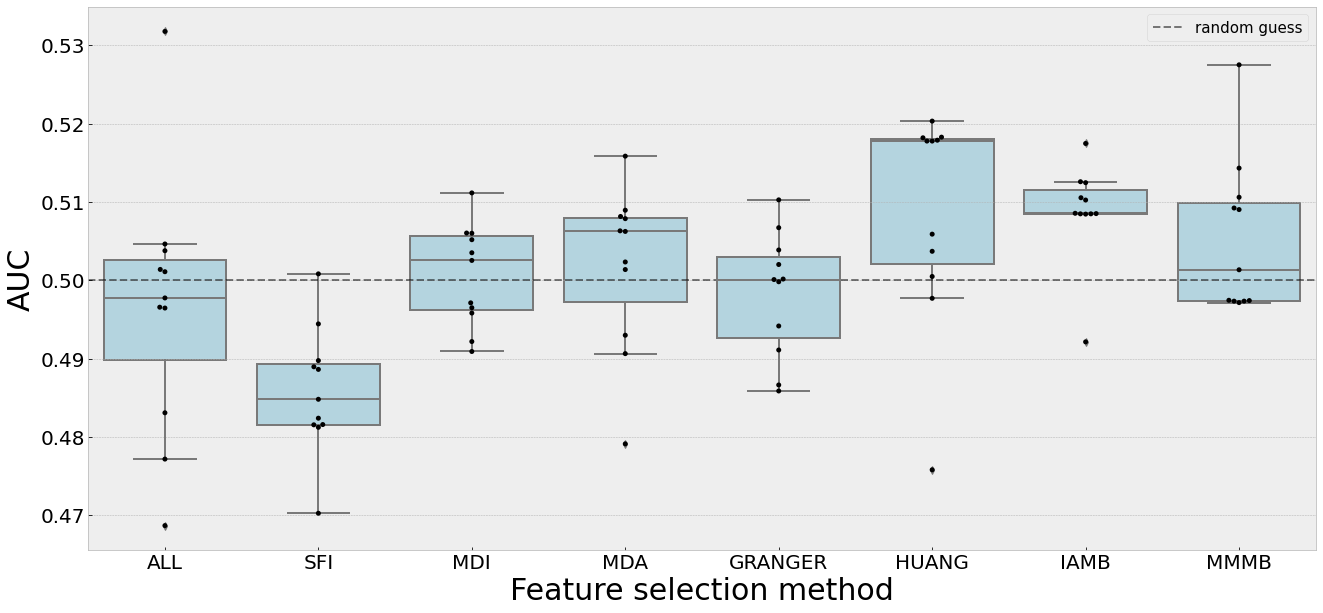

In [23]:
display(Markdown("### 1.6) Out of sample AUC distribution across feature selection methods (SPX index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_spx_auc_df, ax=ax, order=fs_methods2, color='lightblue');
sns.swarmplot(x="fs", y='oosauc',
              data=oos_spx_auc_df,ax=ax,
              color="k",order=fs_methods2)
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr_spx.png')

In [24]:
# print((oos_spx_auc_df1 * 100).reset_index().to_latex(index=False))

In [36]:
predictions_df = oos_melt_predictions_df.copy()

strat = predictions_df['strat_type'].unique()[0]
ticker = predictions_df['ticker'].unique()[0]


strat_df = predictions_df.loc[predictions_df['strat_type'] == strat].drop('strat_type', axis=1)
ticker_strat_df = strat_df.loc[strat_df['ticker'] == ticker]
ticker_strat_pivot_df = ticker_strat_df.pivot_table(index=['date'], columns=['variable', 'ticker', 'model', 'fs'], values=['value'])

In [39]:
ticker_strat_df

date    variable     value   model    fs     ticker
2139  2012-07-03  prediction  0.887274   LOGIT   ALL  SPX Index
2140  2012-07-05  prediction  0.000002   LOGIT   ALL  SPX Index
2141  2012-07-06  prediction  1.000000   LOGIT   ALL  SPX Index
2142  2012-07-09  prediction  0.000048   LOGIT   ALL  SPX Index
2143  2012-07-10  prediction  1.000000   LOGIT   ALL  SPX Index
...          ...         ...       ...     ...   ...        ...
6412  2020-12-24  prediction  0.551179  NNCOMB  MMMB  SPX Index
6413  2020-12-28  prediction  0.551179  NNCOMB  MMMB  SPX Index
6414  2020-12-29  prediction  0.551038  NNCOMB  MMMB  SPX Index
6415  2020-12-30  prediction  0.550749  NNCOMB  MMMB  SPX Index
6416  2020-12-31  prediction  0.551179  NNCOMB  MMMB  SPX Index

[205344 rows x 6 columns]

In [40]:
ticker_strat_df['variable'].unique()

array(['prediction', 'Unnamed: 0'], dtype=object)

In [41]:
ticker_strat_df.loc[ticker_strat_df['variable'] == 'Unnamed: 0']

date    variable   value   model    fs     ticker
0     2012-07-03  Unnamed: 0  1637.0  NNCOMB   ALL  SPX Index
1     2012-07-05  Unnamed: 0  1638.0  NNCOMB   ALL  SPX Index
2     2012-07-06  Unnamed: 0  1639.0  NNCOMB   ALL  SPX Index
3     2012-07-09  Unnamed: 0  1640.0  NNCOMB   ALL  SPX Index
4     2012-07-10  Unnamed: 0  1641.0  NNCOMB   ALL  SPX Index
...          ...         ...     ...     ...   ...        ...
2134  2020-12-24  Unnamed: 0  3771.0  NNCOMB  MMMB  SPX Index
2135  2020-12-28  Unnamed: 0  3772.0  NNCOMB  MMMB  SPX Index
2136  2020-12-29  Unnamed: 0  3773.0  NNCOMB  MMMB  SPX Index
2137  2020-12-30  Unnamed: 0  3774.0  NNCOMB  MMMB  SPX Index
2138  2020-12-31  Unnamed: 0  3775.0  NNCOMB  MMMB  SPX Index

[17112 rows x 6 columns]

In [25]:
oos_pred_ret_df, oos_pred_pos_df = gen_strat_positions_and_ret_from_pred(predictions_df=oos_melt_predictions_df,
                                                                         class_threshold=0.5,
                                                                         target_asset_returns=benchmark_df)

ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)

oos_benchmark_df = benchmark_df.loc[(benchmark_df['date'])>= oos_start_date]
pivot_oos_benchmark_df = oos_benchmark_df.pivot_table(index=['date'], columns=['model'], values=['value']).dropna()
pivot_oos_benchmark_df.columns = pivot_oos_benchmark_df.columns.droplevel()
pivot_oos_benchmark_df['Combined portfolio'] = pivot_oos_benchmark_df.mean(axis=1)

ann_avg_ret_benchmark = (pivot_oos_benchmark_df.mean() * 252).reset_index()
ann_avg_ret_benchmark.columns = ['ticker', 'Ann Avg Return']
ann_avg_ret = ann_avg_ret_benchmark.loc[ann_avg_ret_benchmark['ticker'] == 'Combined portfolio']['Ann Avg Return'].iloc[0]

ann_vol_benchmark = (pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
ann_vol_benchmark.columns = ['ticker', 'Ann Volatility']
ann_vol_ret = ann_vol_benchmark.loc[ann_vol_benchmark['ticker'] == 'Combined portfolio']['Ann Volatility'].iloc[0]

sr_benchmark = (pivot_oos_benchmark_df.mean() / pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
sr_benchmark.columns = ['ticker', 'sharpe ratio']
average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'Combined portfolio']['sharpe ratio'].iloc[0]

cum_prod_df = (1 + pivot_oos_benchmark_df / 100).cumprod()
previous_peaks_df = cum_prod_df.cummax()
mdd_df = (cum_prod_df - previous_peaks_df) / previous_peaks_df
mdd_df = pd.DataFrame(mdd_df.min().sort_values(ascending=False) * 100).reset_index()
mdd_df.columns = ['ticker', 'max drawdown']
average_mdd = mdd_df.loc[mdd_df['ticker'] == 'Combined portfolio']['max drawdown'].iloc[0]

ValueError: cannot handle a non-unique multi-index!

## 2) Annualiazed average returns

### 2.1) Out of sample Ann. Avg. Returns values median values (average benchmark 16.318)

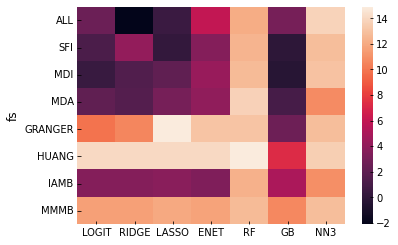

In [64]:
ann_avg_ret_rank_df, ann_avg_ret_tb_df, ann_avg_ret_agg_df = ann_avg_returns_tb(returns_df=ret_all_df.dropna(),
                                                                                level_to_subset='fs',
                                                                                rf=.0)

ann_avg_ret_df = ann_avg_ret_rank_df.reset_index()
ann_avg_ret_raw = ann_avg_ret_df.loc[ann_avg_ret_df["fs"]=="raw"].reset_index(drop=True)
ann_avg_ret_df = ann_avg_ret_df.loc[ann_avg_ret_df["fs"]!="raw"].reset_index(drop=True)
ann_avg_ret_df_spx = ann_avg_ret_df.loc[ann_avg_ret_df["ticker"]=="SPX Index"].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == ann_avg_ret_df.shape[0]

simple_ann_avg_ret_df = ann_avg_ret_df.pivot_table(index=['fs'], columns=['model'], values=['Ann Avg Return'], aggfunc='median')
simple_cols = [c[1] for c in simple_ann_avg_ret_df.columns]
simple_ann_avg_ret_df.columns = simple_cols
simple_ann_avg_ret_df = simple_ann_avg_ret_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Ann. Avg. Returns values median values (average benchmark {:.3f})".format(ann_avg_ret)))
display(HTML(simple_ann_avg_ret_df.to_html()))
sns.heatmap(simple_ann_avg_ret_df);

## 3) Annualiazed volatility

### 2.1) Out of sample Ann. Volatility values median values (average benchmark 18.998)

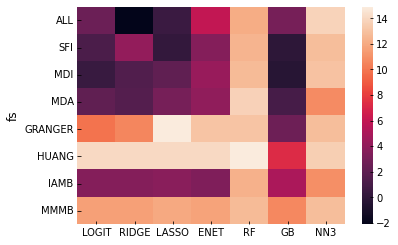

In [65]:
vol_rank_df, vol_tb_df, vol_agg_df = ann_vol_tb(returns_df=ret_all_df.dropna(),
                                                level_to_subset='fs',
                                                rf=.0)

vol_df = vol_rank_df.reset_index()
vol_df_raw = vol_df.loc[vol_df["fs"]=="raw"].reset_index(drop=True)
vol_df = vol_df.loc[vol_df["fs"]!="raw"].reset_index(drop=True)
vol_df_spx = vol_df.loc[vol_df["ticker"]=="SPX Index"].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == vol_df.shape[0]

simple_vol_df = vol_df.pivot_table(index=['fs'], columns=['model'], values=['Ann Volatility'], aggfunc='median')
simple_cols = [c[1] for c in simple_vol_df.columns]
simple_vol_df.columns = simple_cols
simple_vol_df = simple_vol_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Ann. Volatility values median values (average benchmark {:.3f})".format(ann_vol_ret)))
display(HTML(simple_ann_avg_ret_df.to_html()))
sns.heatmap(simple_ann_avg_ret_df);

## 4) Max Drawdown

### 2.1) Out of sample Max. Drawdown values median values (average benchmark -40.036)

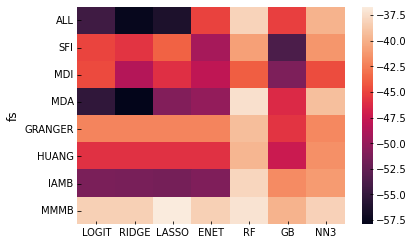

In [72]:
mdd_rank_df, mdd_tb_df, mdd_agg_df = max_drawdown_tb(returns_df=ret_all_df.dropna(),
                                                     level_to_subset='fs')

mdd_df = mdd_rank_df.reset_index()
mdd_df_raw = mdd_df.loc[mdd_df["fs"]=="raw"].reset_index(drop=True)
mdd_df = mdd_df.loc[mdd_df["fs"]!="raw"].reset_index(drop=True)
mdd_df_spx = mdd_df.loc[mdd_df["ticker"]=="SPX Index"].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == mdd_df.shape[0]

simple_mdd_df = mdd_df.pivot_table(index=['fs'], columns=['model'], values=['max drawdown'], aggfunc='median')
simple_cols = [c[1] for c in simple_mdd_df.columns]
simple_mdd_df.columns = simple_cols
simple_mdd_df = simple_mdd_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Max. Drawdown values median values (average benchmark {:.3f})".format(average_mdd)))
display(HTML(simple_mdd_df.to_html()))
sns.heatmap(simple_mdd_df);

## 5) Sharpe ratio

### 2.1) Out of sample Sharpe values median values (average benchmark 0.859)

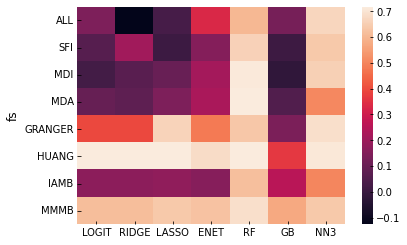

In [73]:
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)

sr_df = sr_rank_df.reset_index()
sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
sr_df_spx = sr_df.loc[sr_df["ticker"]=="SPX Index"].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == sr_df.shape[0]

simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_sr_df.columns]
simple_sr_df.columns = simple_cols
simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Sharpe values median values (average benchmark {:.3f})".format(average_sr)))
display(HTML(simple_sr_df.to_html()))
sns.heatmap(simple_sr_df);

In [19]:
# print((simple_sr_df).reset_index().to_latex(index=False))

In [20]:
# display(Markdown("### 2.2) Out of sample Sharpe ratio distribution across models"))

# fig, ax = plt.subplots(figsize=(22,10))
# sns.boxplot(x="model", y='sharpe ratio',data=sr_df, ax=ax, order=models2);
# ax.set_ylabel("Sharpe ratio", fontsize=30);
# ax.set_xlabel("Model", fontsize=30);
# ax.axhline(y=average_sr,
#            color='k',
#            linestyle='--',
#            alpha=0.5, label="Average Sharpe ratio");
# ax.tick_params(axis="x", labelsize=20);
# ax.tick_params(axis="y", labelsize=20);
# ax.legend(loc="best",fontsize=15);
# fig.savefig('img/oos_sr_models_distr.png')

In [21]:
# display(Markdown("### 2.3) Out of sample Sharpe ratio distribution across feature selection methods"))

# fig, ax = plt.subplots(figsize=(22,10))
# sns.boxplot(x="fs", y='sharpe ratio',data=sr_df, ax=ax, order=fs_methods2);
# ax.set_ylabel("Sharpe ratio", fontsize=30);
# ax.set_xlabel("Feature selection method", fontsize=30);
# ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
# ax.tick_params(axis="x", labelsize=20);
# ax.tick_params(axis="y", labelsize=20);
# ax.legend(loc="best",fontsize=15);
# fig.savefig('img/oos_sr_fs_methods_distr.png')

### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark 0.914)

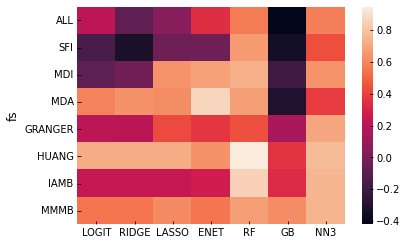

In [22]:
snp_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']=='SPX Index')].reset_index(drop=True)
snp_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']=='SPX Index')].reset_index(drop=True)

# snp_average_sr = np.median([snp_sr_df.groupby(by=['model'], as_index=True).median()['sharpe ratio'].median(), snp_sr_df.groupby(by=['fs'], as_index=True).median()['sharpe ratio'].median()])
snp_average_sr = average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'SPX Index']['sharpe ratio'].iloc[0]

snp_simple_sr_df = snp_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in snp_simple_sr_df.columns]
snp_simple_sr_df.columns = simple_cols
snp_simple_sr_df = snp_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark {:.3f})".format(snp_average_sr)))
display(HTML(snp_simple_sr_df.to_html()))
sns.heatmap(snp_simple_sr_df);

In [23]:
for ticker in sr_df['ticker'].unique():
    aux_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)
    aux_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)

    aux_average_sr = average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ticker]['sharpe ratio'].iloc[0]

    aux_simple_sr_df = aux_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
    simple_cols = [c[1] for c in aux_simple_sr_df.columns]
    aux_simple_sr_df.columns = simple_cols
    aux_simple_sr_df = aux_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 2.1) Out of sample Sharpe values median values " + ticker + " (median benchmark {:.3f})".format(aux_average_sr)))
    display(HTML(aux_simple_sr_df.to_html()))
    # sns.heatmap(aux_simple_sr_df);

### 2.1) Out of sample Sharpe values median values SPX Communications (median benchmark 1.057)

### 2.1) Out of sample Sharpe values median values SPX Technology (median benchmark 1.250)

### 2.1) Out of sample Sharpe values median values SPX Consumer Non cyclical (median benchmark 1.193)

### 2.1) Out of sample Sharpe values median values SPX Utilities (median benchmark 0.673)

### 2.1) Out of sample Sharpe values median values CCMP Index (median benchmark 1.083)

### 2.1) Out of sample Sharpe values median values SPX Industrial (median benchmark 0.916)

### 2.1) Out of sample Sharpe values median values SPX Index (median benchmark 0.914)

### 2.1) Out of sample Sharpe values median values SPX Financial (median benchmark 0.715)

### 2.1) Out of sample Sharpe values median values SPX Consumer Cyclical (median benchmark 0.794)

### 2.1) Out of sample Sharpe values median values RTY Index (median benchmark 0.673)

### 2.1) Out of sample Sharpe values median values SPX Energy (median benchmark 0.058)

### 2.1) Out of sample Sharpe values median values SPX Basic Materials (median benchmark 0.663)

In [24]:
# for ticker in sr_df['ticker'].unique():
#     aux_sr_df_raw = sr_df.loc[(sr_df["fs"]=="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)
#     aux_sr_df = sr_df.loc[(sr_df["fs"]!="raw")&(sr_df['ticker']==ticker)].reset_index(drop=True)

#     aux_average_sr = np.median([aux_sr_df.groupby(by=['model'], as_index=True).median()['sharpe ratio'].median(), aux_sr_df.groupby(by=['fs'], as_index=True).median()['sharpe ratio'].median()])

#     aux_simple_sr_df = aux_sr_df.pivot_table(index=['fs'], columns=['model'], values=['sharpe ratio'], aggfunc='median')
#     simple_cols = [c[1] for c in aux_simple_sr_df.columns]
#     aux_simple_sr_df.columns = simple_cols
#     aux_simple_sr_df = aux_simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

#     display(Markdown("### 2.1) Out of sample Sharpe values median values " + ticker + " (median benchmark {:.3f})".format(aux_average_sr)))
#     print((aux_simple_sr_df).reset_index().to_latex(index=False))
#     # sns.heatmap(aux_simple_sr_df);

### 2.4) Out of sample Sharpe ratio distribution across forecasting models (SPX Index only)

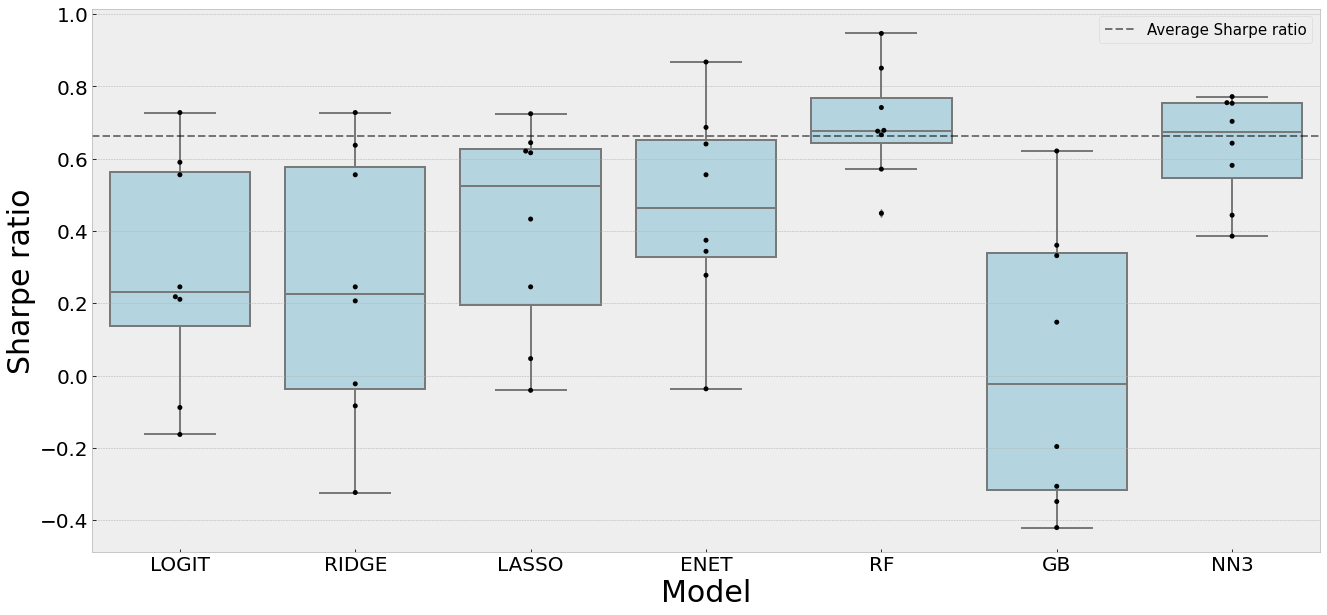

In [25]:
display(Markdown("### 2.4) Out of sample Sharpe ratio distribution across forecasting models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='sharpe ratio',data=sr_df_spx, ax=ax, order=models2, color='lightblue');
sns.swarmplot(x="model", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=models2)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_models_distr_spx.png')

### 2.5) Out of sample Sharpe ratio distribution across feature selection models (SPX Index only)

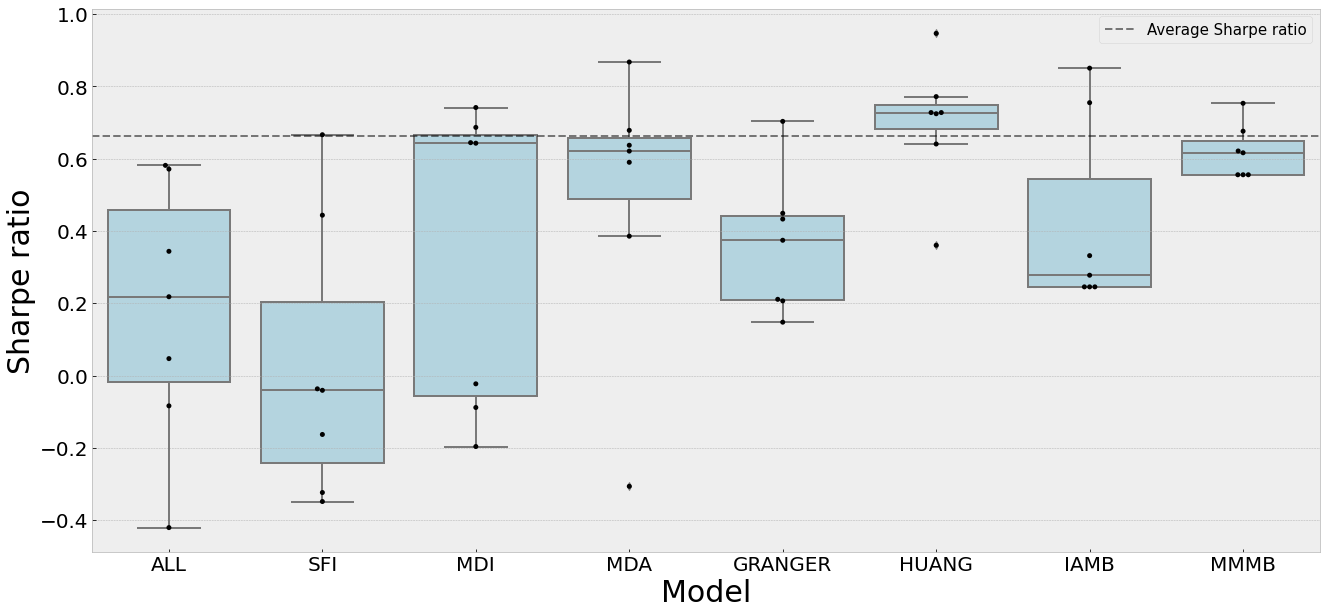

In [26]:
display(Markdown("### 2.5) Out of sample Sharpe ratio distribution across feature selection models (SPX Index only)"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='sharpe ratio',data=sr_df_spx, ax=ax, order=fs_methods2, color='lightblue');
sns.swarmplot(x="fs", y='sharpe ratio',
              data=sr_df_spx,ax=ax,
              color="k",order=fs_methods2)
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr,
           color='k',
           linestyle='--',
           alpha=0.5, label="Average Sharpe ratio");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_sr_fs_methods_distr_spx.png')

## 3) Cummulative returns

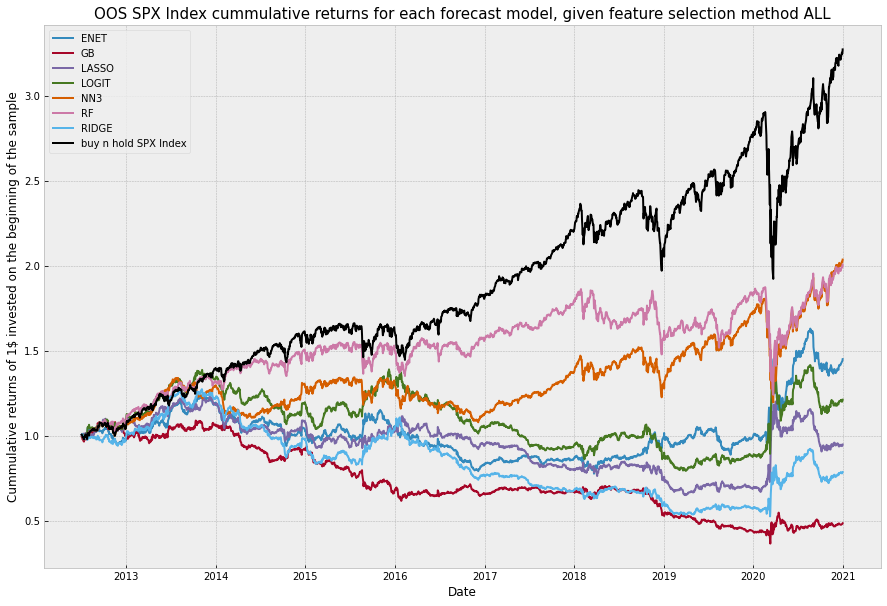

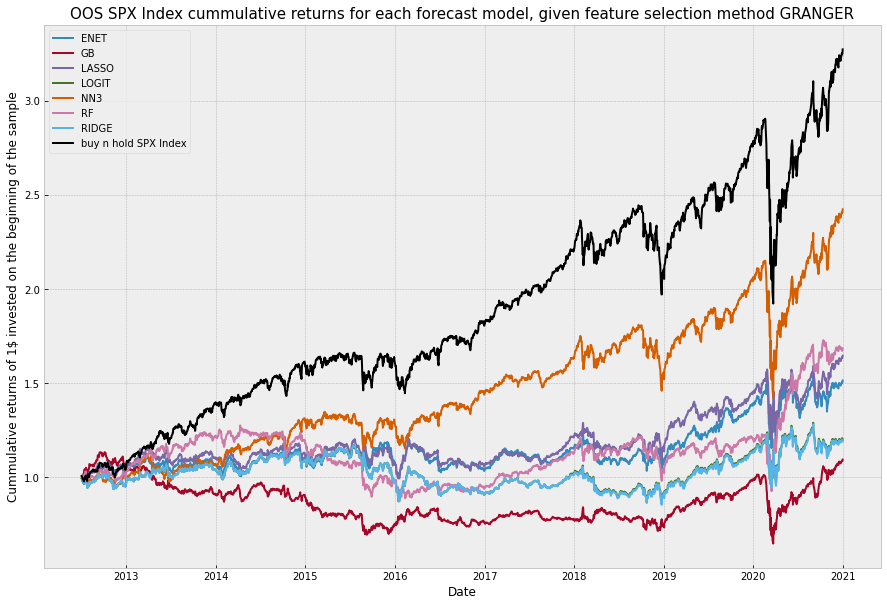

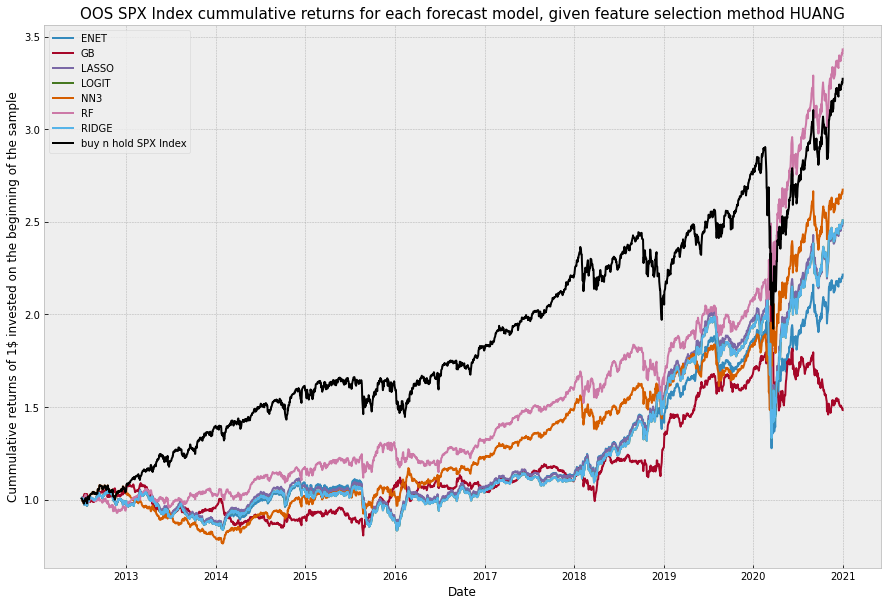

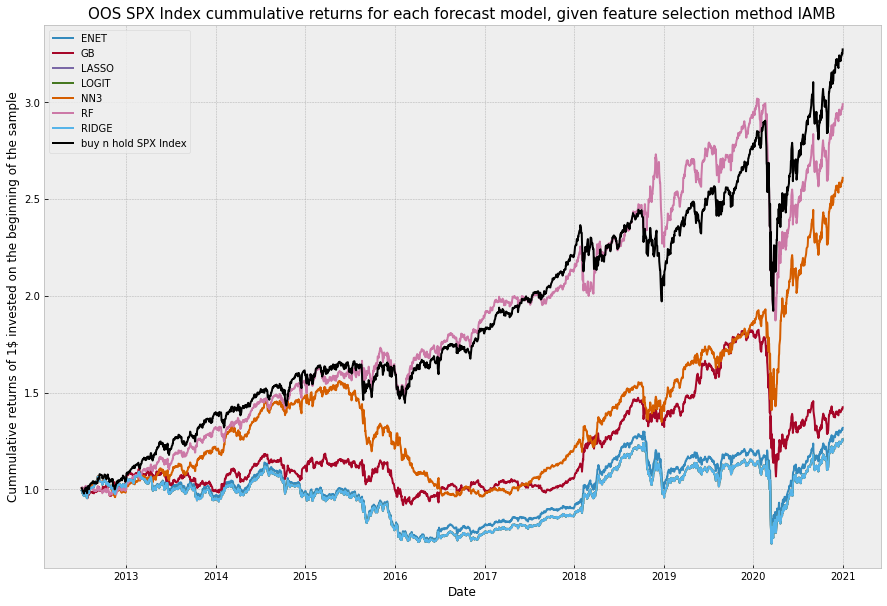

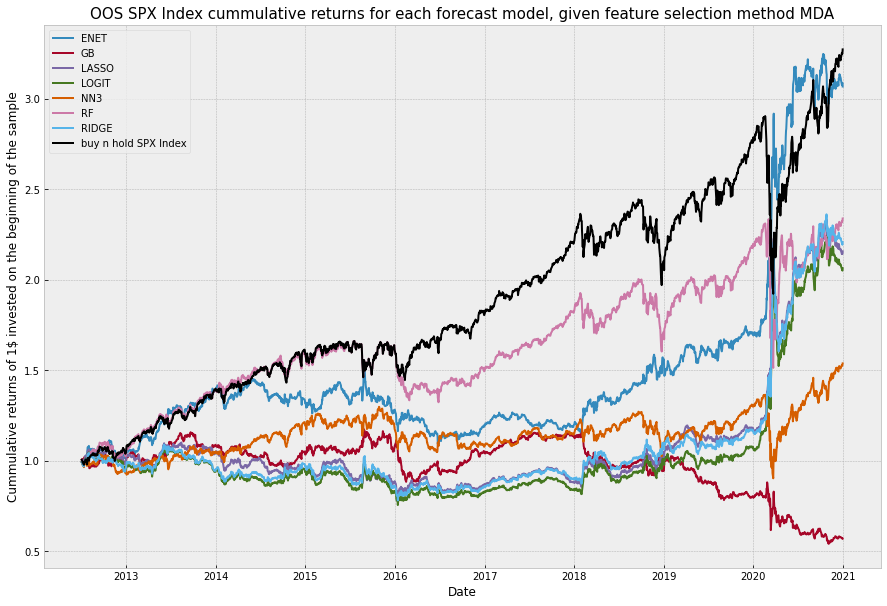

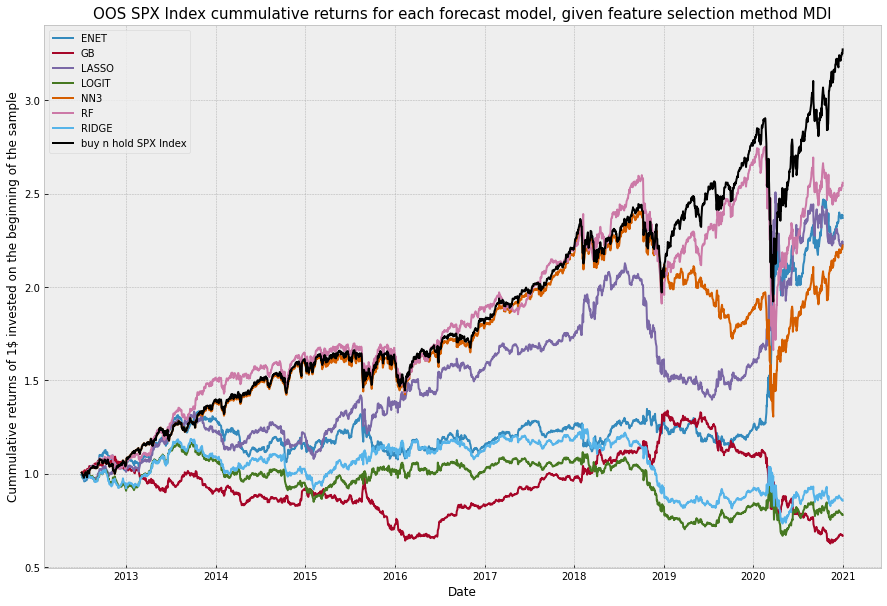

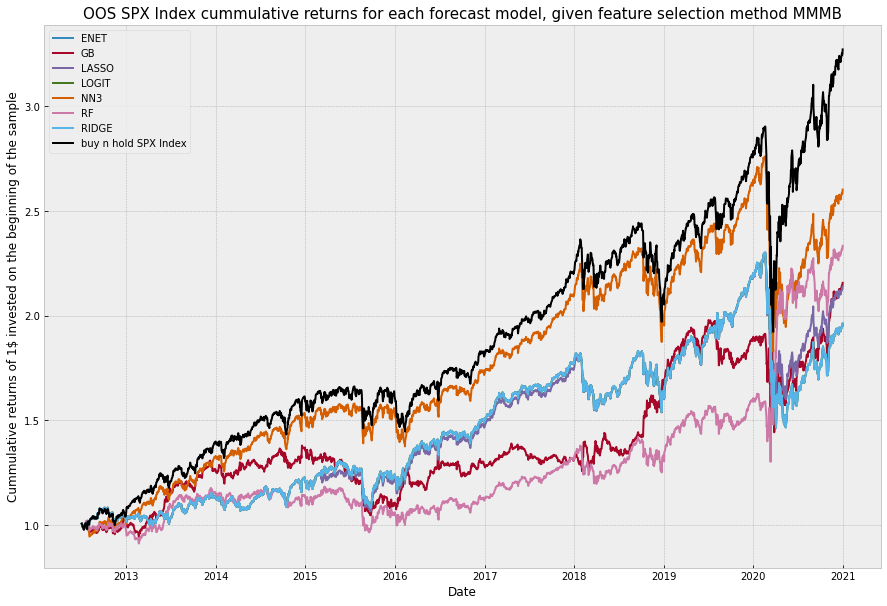

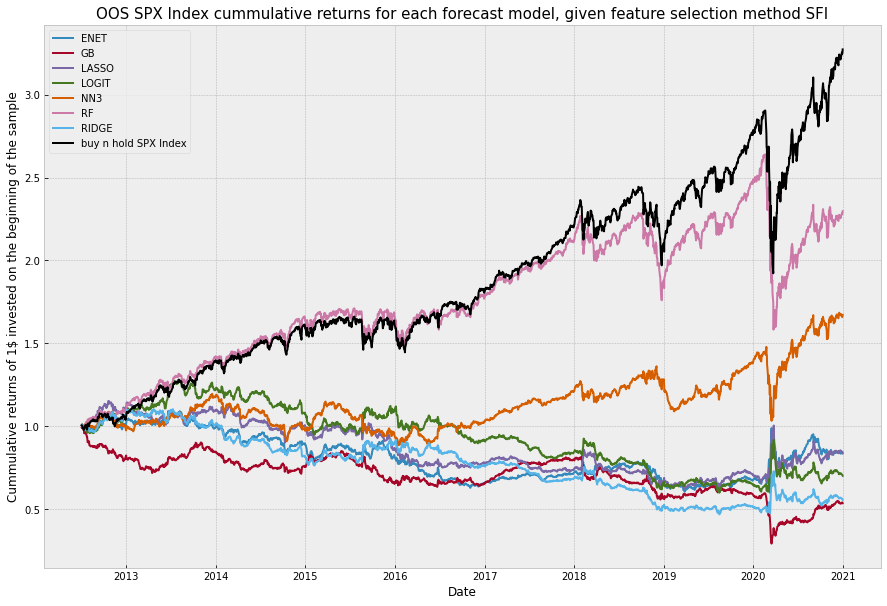

In [28]:
ticker = 'SPX Index'

summary_oos_pred_ret_df = oos_pred_ret_df.loc[oos_pred_ret_df['ticker']==ticker]
summary_benchmark_df = benchmark_df.loc[benchmark_df['ticker']==ticker]

for key1 in summary_oos_pred_ret_df['fs'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label='OOS ' + ticker + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['model'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == key1)&
                                              (summary_oos_pred_ret_df['model'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
    plt.show()

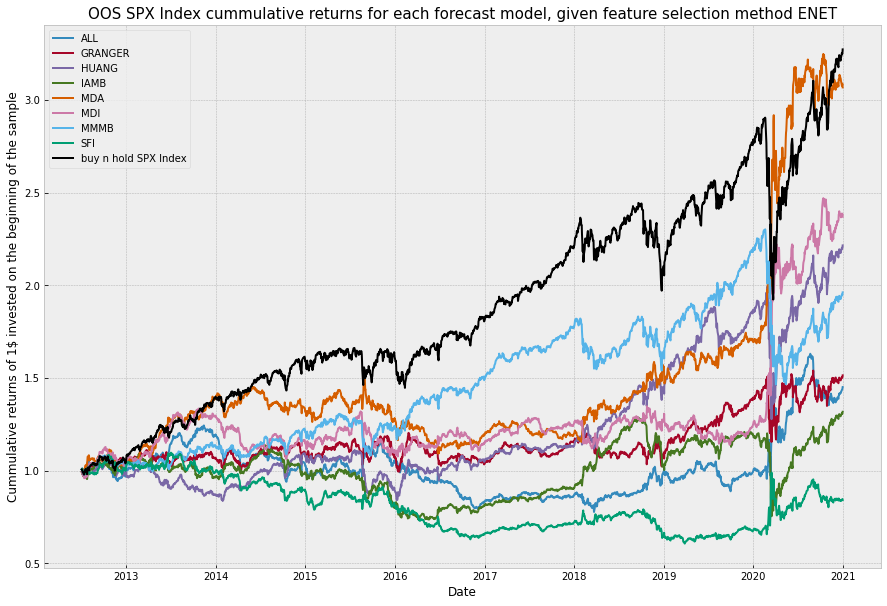

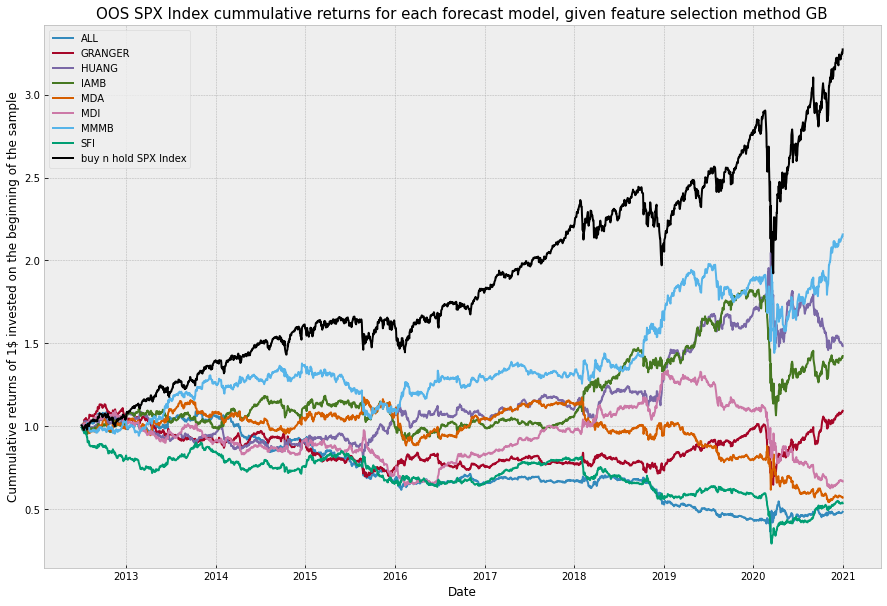

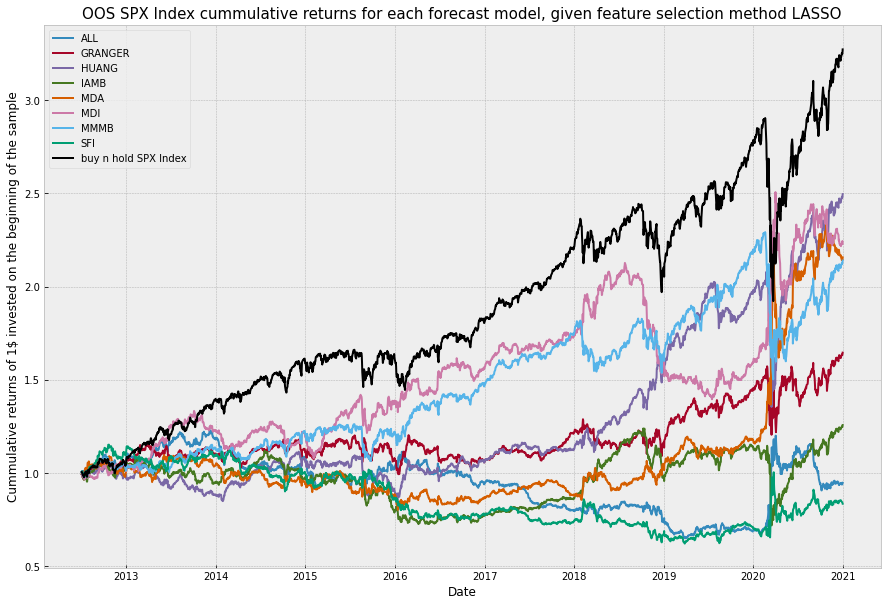

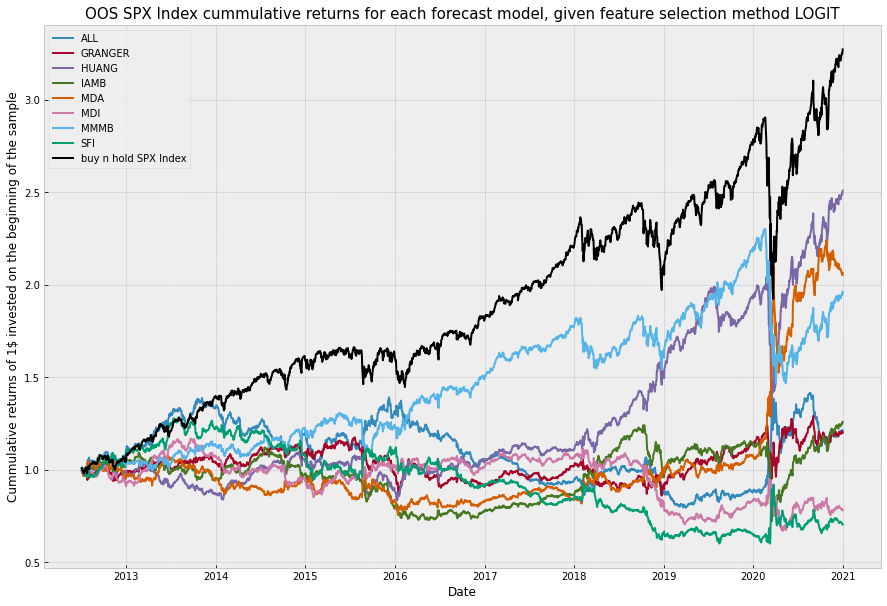

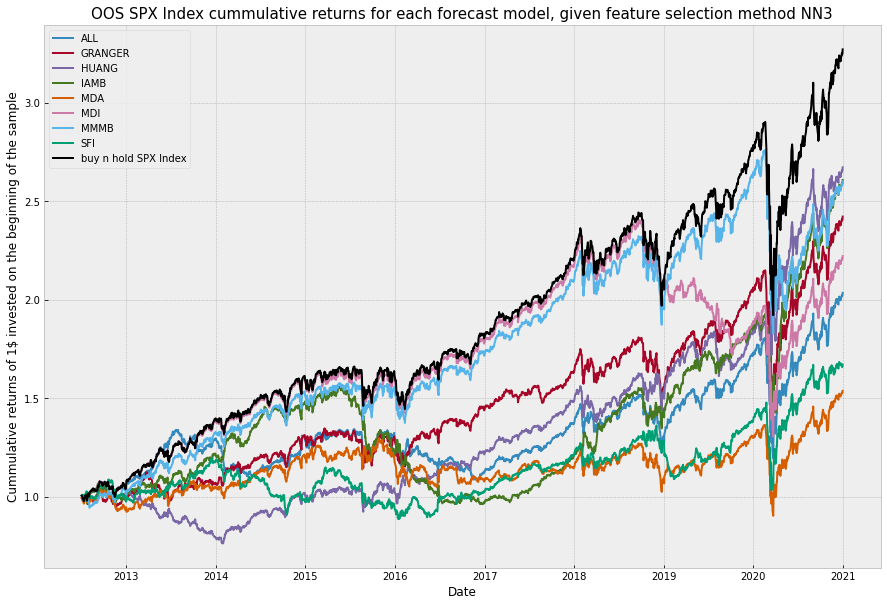

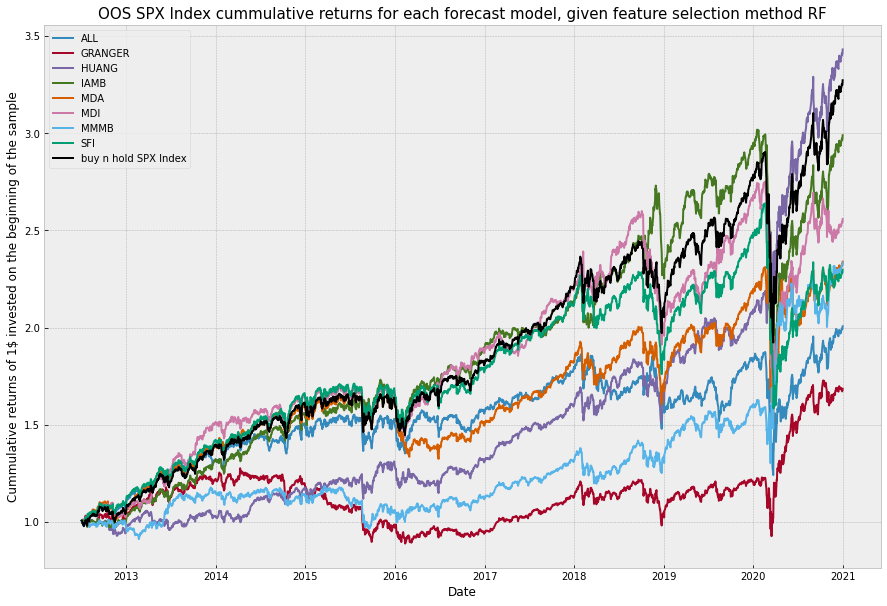

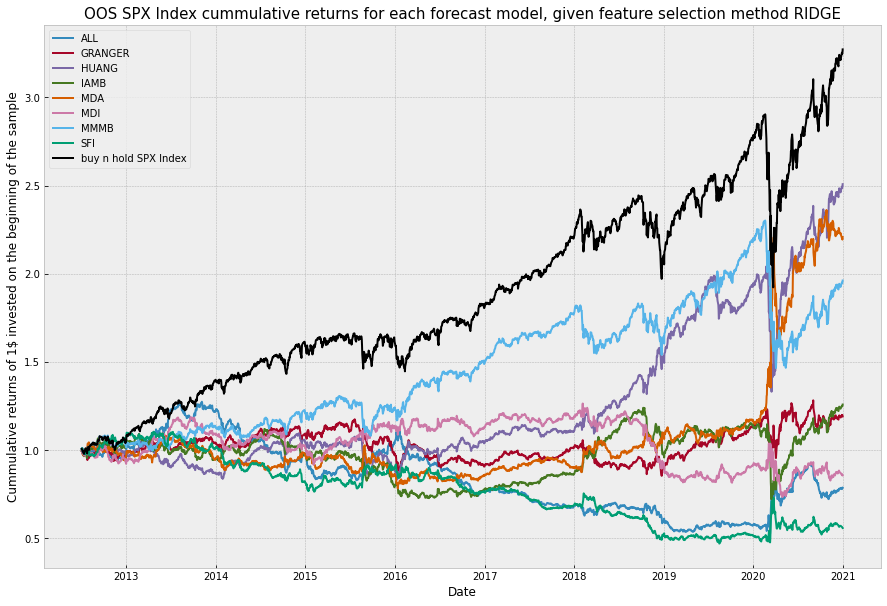

In [29]:
for key1 in summary_oos_pred_ret_df['model'].unique():
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(label='OOS ' + ticker + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

    for key2 in summary_oos_pred_ret_df['fs'].unique():
        loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['model'] == key1)&
                                              (summary_oos_pred_ret_df['fs'] == key2)&
                                              (summary_oos_pred_ret_df['ticker'] == ticker)]
        ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

    bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
    ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)
    
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)    
    fig.savefig('img/' + ticker + '_' + key1 + '_models.png')
    plt.show()

## 4) Simulation comparison between the Sharpe ratio and the AUC

In [30]:
spx_df = benchmark_df.loc[benchmark_df['ticker']=='SPX Index']
oos_spx_df = spx_df.loc[spx_df['date']>=oos_start_date]
pivot_oos_spx_df = oos_spx_df.pivot_table(index=['date'], columns=['ticker'], values=['value'])
pivot_oos_spx_df.columns = pivot_oos_spx_df.columns.droplevel()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


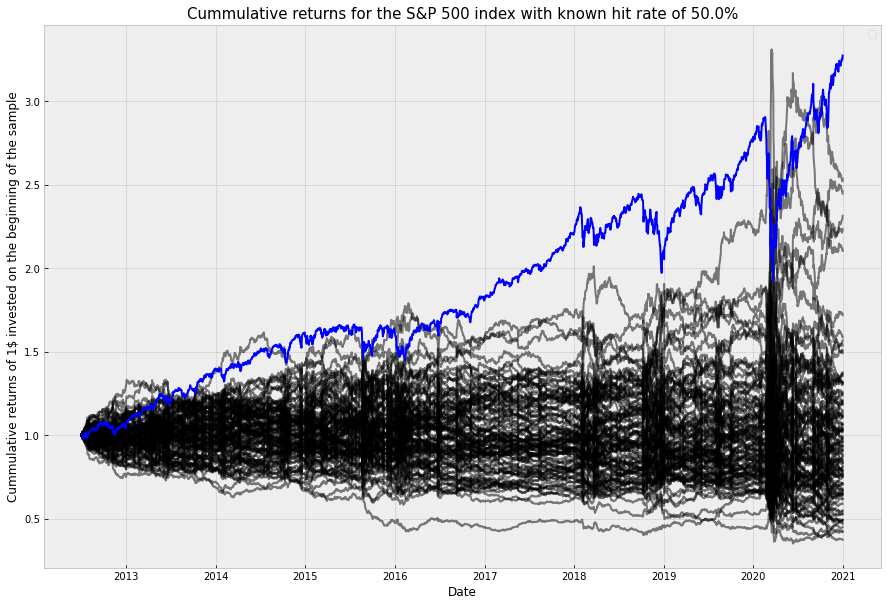

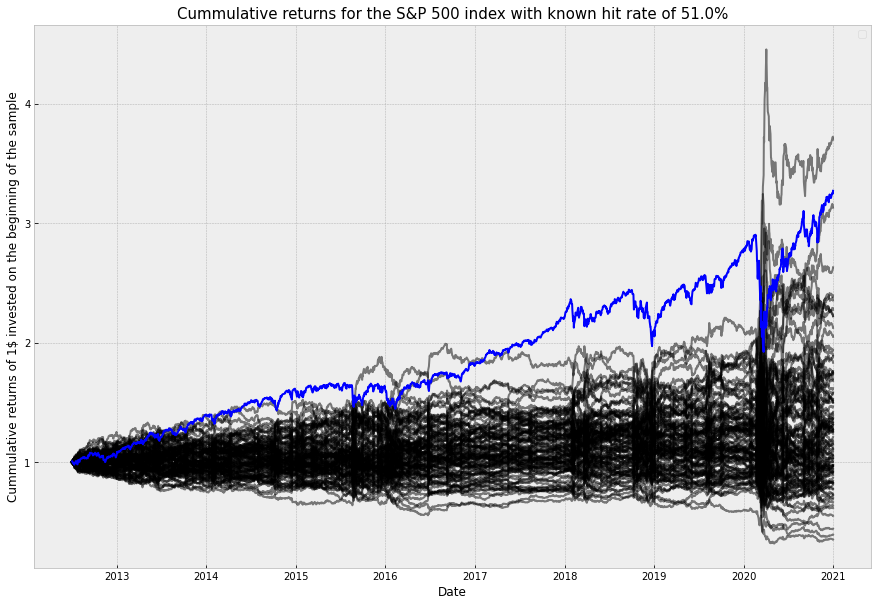

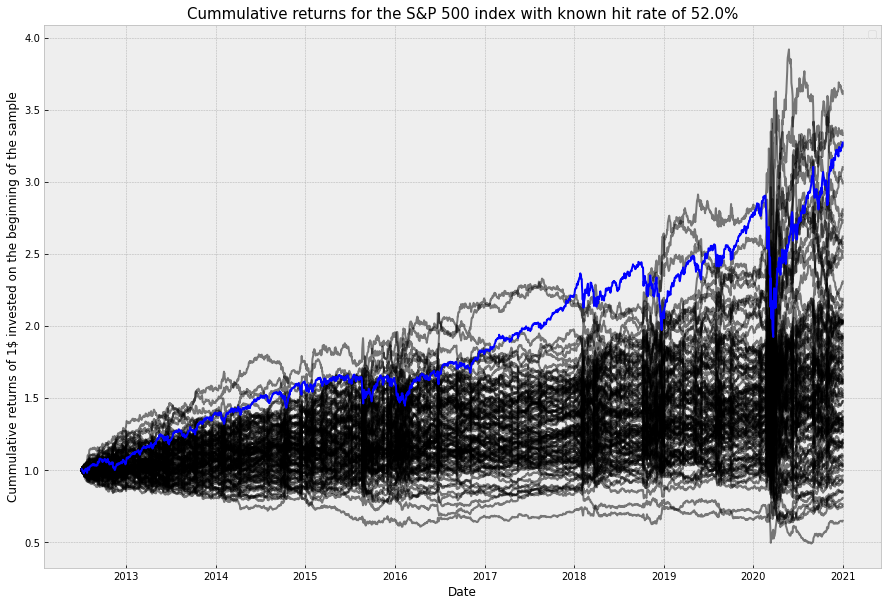

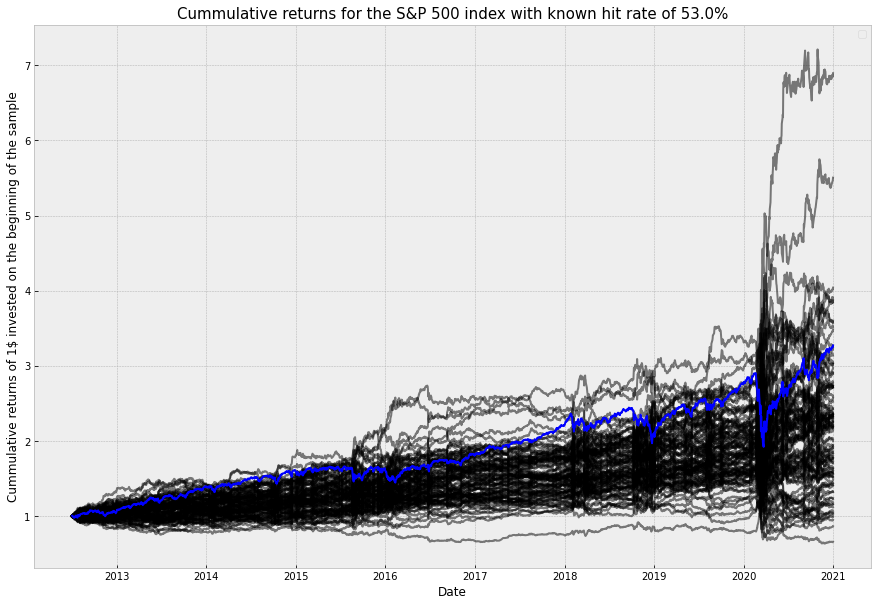

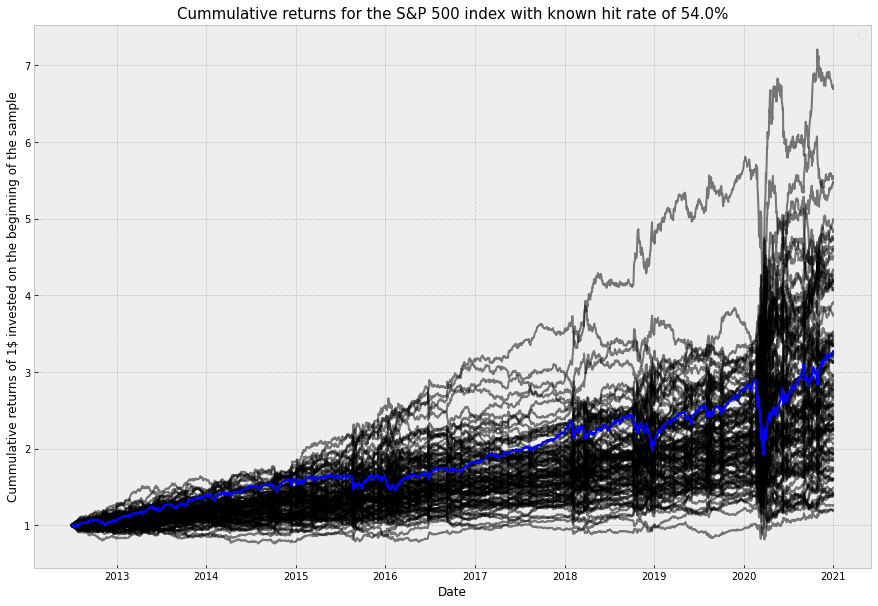

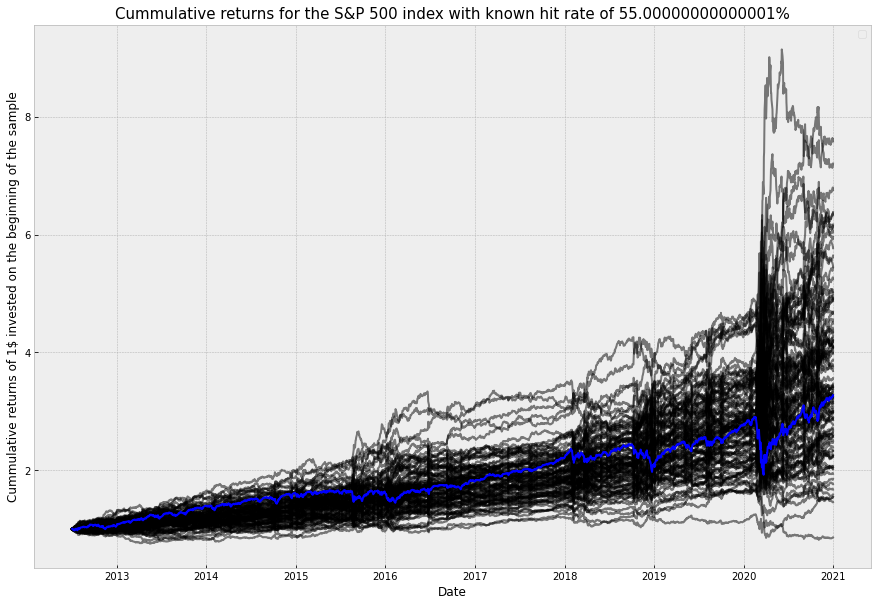

In [31]:
simu_num = 100
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index

    out_simu_df = pd.concat([out_simu_df, pivot_oos_spx_df], axis=1)
    out_simu_df = out_simu_df.reset_index()

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Cummulative returns for the S&P 500 index with known hit rate of ' + str(p*100) + '%',
                fontsize=15)

    for key in out_simu_df.columns:
        if key == 'date':
            continue

        if key == 'SPX Index':
            ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='blue')
        else:
             ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='black',
                    alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)    
    fig.savefig('img/' + 'known_hitrate' + str(np.round(p)) + '_spx_simulation.png')
plt.show()

In [32]:
simu_num = 1000
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

out_list = []
for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index
    
    hist_simu = out_simu_df.mean() / out_simu_df.std() * np.sqrt(252)
    hist_simu = hist_simu.reset_index()
    hist_simu.rename(columns={hist_simu.columns[1]: 'value'}, inplace=True)
    hist_simu['auc'] = str(p)
    
    out_list.append(hist_simu)
out_simu_df = pd.concat(out_list, axis=0)
out_simu_df.rename(columns={'value': 'sharpe ratio'}, inplace=True)

### 1.3) Sharpe ratio distirbution for simulated strategies with fixed AUC

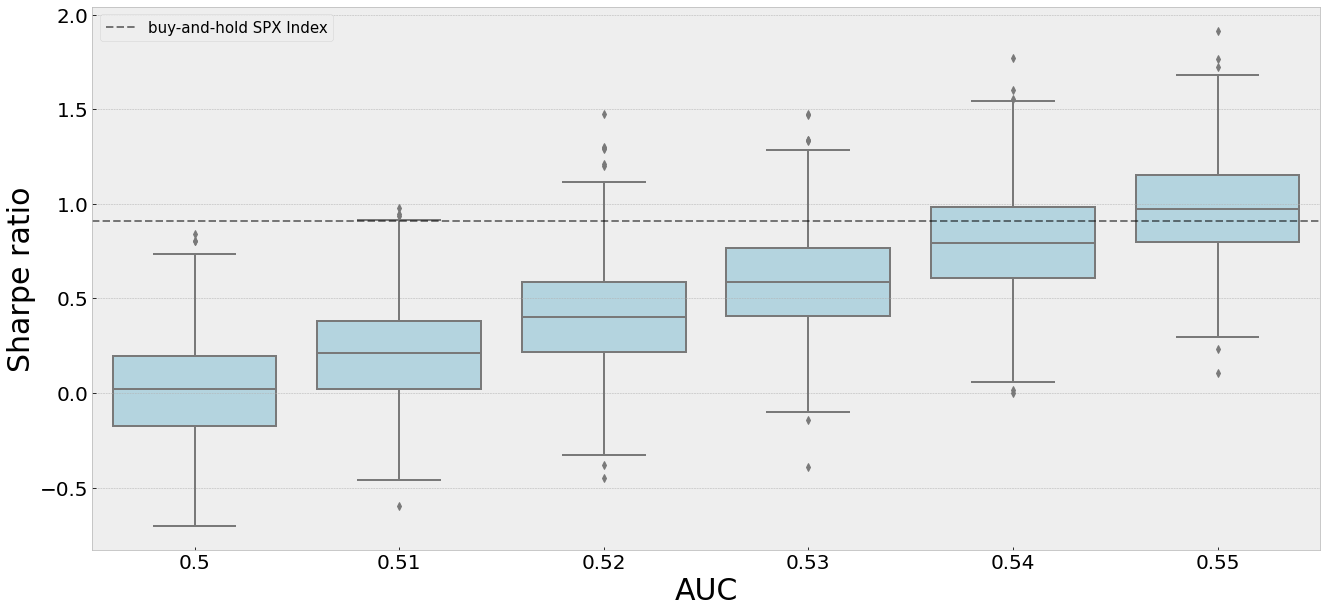

In [33]:
display(Markdown("### 1.3) Sharpe ratio distirbution for simulated strategies with fixed AUC"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="auc", y='sharpe ratio',data=out_simu_df, ax=ax, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("AUC", fontsize=30);
ax.axhline(y=0.91, color='k', linestyle='--', alpha=0.5, label="buy-and-hold SPX Index");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/boxplot_simu_sr_known_auc.png')

In [ ]:
tot_time = time() - init
tot_time = tot_time / 60
print("notebook time = {:.3f} (minutes)".format(tot_time))